# Autoencoders - Colorization

This notebook shows autoencoders for colorization of black and white images. The flowers data is used to ilustrate the concept.

The images are initially converted to Lab color space. The input is the L channel, and the target are the (a,b) channels.

Transfer learning is used for the encoder. A VGG16 with imagenet weights is used as the base model for the encoder.

- dataset: https://www.tensorflow.org/datasets/catalog/tf_flowers

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

# to display confusion matrix
import seaborn as sn
import pandas as pd

import cv2

## Auxiliary functions 

In [3]:
def show_sample():
    columns = 5
    rows = 5
    plt.figure(figsize=(20, 20))
    n = 1
    for d in os.listdir(data):
        fs = os.listdir(f'{data}{d}')
        for f in fs[:5]:
            img = cv2.imread(f'{data}{d}/{f}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
            ax = plt.subplot(rows, columns, n)
            plt.imshow((img))
            plt.axis('off')
            n += 1
        
        
def showLAB(filename):
    
    img = cv2.imread(filename)
    img = cv2.resize(img, (WIDTH,HEIGHT))
    LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    plt.figure(figsize=(15, 60))
    ax = plt.subplot(1,4,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("RGB");
    ax = plt.subplot(1,4,2)
    plt.title("L");
    plt.imshow(LAB[:,:,0], cmap='gray')
    ax = plt.subplot(1,4,3)
    plt.title("a");
    plt.imshow(LAB[:,:,1], cmap='gray')
    ax = plt.subplot(1,4,4)
    plt.title("b");
    plt.imshow(LAB[:,:,2], cmap='gray')
   
        
def eval_images(filenames):
    
    k = len(filenames)
    rows = k
    cols = 3
    print(rows,cols)
    f, axes= plt.subplots(rows,cols,figsize=(4 * cols,4 * rows))
    fig=plt.figure()
    for a in range (len(filenames)):
        img = cv2.imread(filenames[a])
        img = cv2.resize(img, (WIDTH,HEIGHT))
        LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        x = LAB[:,:,0] 
        x = x.reshape((WIDTH, HEIGHT, 1))
        x = np.concatenate((x,)*3, axis=-1)
        xx = tf.keras.applications.vgg16.preprocess_input(x)

        ab = model.predict(xx.reshape(1,WIDTH,HEIGHT,3))

        cur = np.zeros((192, 192, 3))
        cur[:,:,0] = x[:,:,0] / 255.0
        cur[:,:,1:] = ab 
        cur = np.clip((cur * 255).astype(np.ubyte), 0, 255)

        rgb = cv2.cvtColor(cur, cv2.COLOR_Lab2RGB)
        
        subplot_title="original"
        axes.ravel()[3*a].set_title(subplot_title)  
        axes.ravel()[3*a].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        subplot_title="bw input"
        axes.ravel()[3*a+1].set_title(subplot_title)  
        axes.ravel()[3*a+1].imshow(x)
        subplot_title="output"
        axes.ravel()[3*a+2].set_title(subplot_title)  
        axes.ravel()[3*a+2].imshow(rgb)
    fig.tight_layout()    
    plt.show()
    
    

In [4]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_loss',
                               verbose=1, 
                               save_best_only = True)


    earlyStopper = EarlyStopping(monitor='val_loss',  
        min_delta = 0.00001, patience = 20, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', 
         factor=0.5, patience=5, min_lr=0.0000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

## Configuration

In [5]:
HEIGHT = 192
WIDTH = 192
NUM_CHANNELS = 3
BATCH_SIZE = 32

In [6]:
data_test = 'D:/deepLearning/datasets/flowers/test_ARF/'
data = 'D:/deepLearning/datasets/flowers/train/'
model_prefix = 'd:/vcpi/DL07/flowers/'

train_online = False

## Load Flowers dataset

In [7]:
classNames = np.array(os.listdir(data))
classNames

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

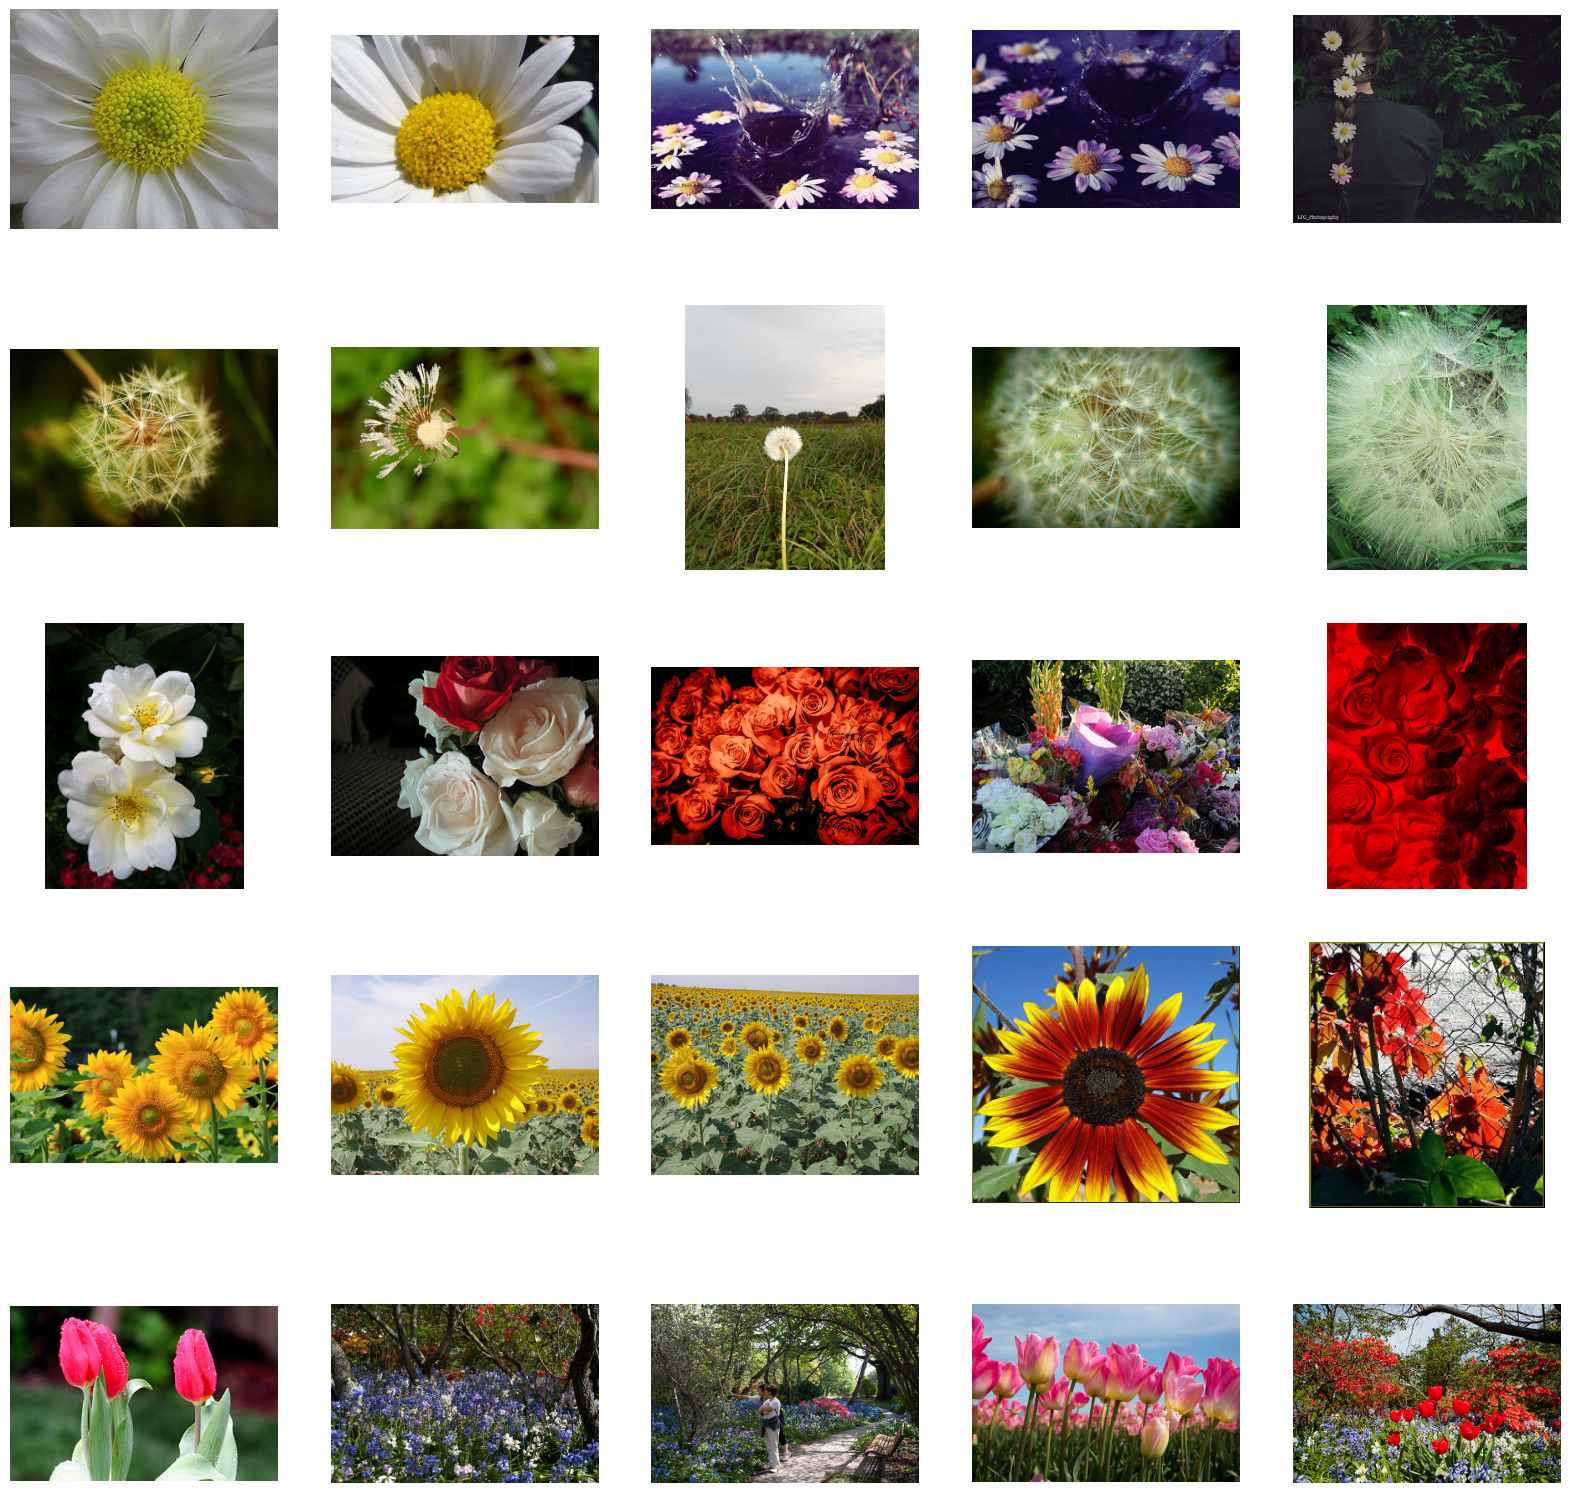

In [8]:
show_sample()

In [9]:
def load_dataset(folder):
    train_X = [] 
    train_Y = [] 

    classes = os.listdir(folder)
    for c in classes:
        if c != 'LICENSE.txt':
            path = folder + c
            files = os.listdir(path)
            for f in files:

                img = cv2.imread(f'{path}/{f}')
                img = cv2.resize(img, (WIDTH,HEIGHT))
                LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

                # input image is L channel in RGB model (3 values per pixel)
                x = LAB[:,:,0] 
                x = x.reshape((WIDTH, HEIGHT, 1))
                x = np.concatenate((x,)*3, axis=-1)
                x = tf.keras.applications.vgg16.preprocess_input(x)

                # output image contains both the a and b channels
                y = LAB[:,:,1:] / 255.0
                train_X.append(x)
                train_Y.append(y)

    return np.asarray(train_X), np.asarray(train_Y)


train_X, train_Y = load_dataset(data)
print(train_X.shape, train_Y.shape)
  
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).shuffle(train_X.shape[0])

(3670, 192, 192, 3) (3670, 192, 192, 2)


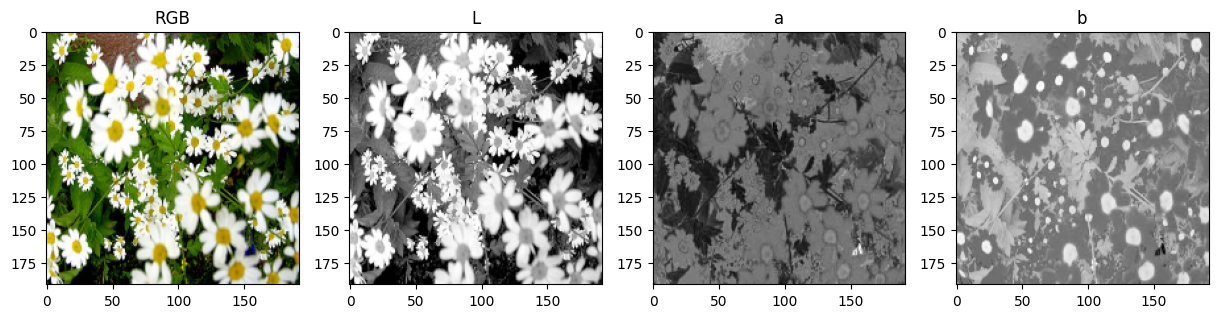

In [10]:
showLAB( f'{data}daisy/181007802_7cab5ee78e_n.jpg')

In [11]:
train = train_dataset.take(int(0.8*train_X.shape[0])).batch(BATCH_SIZE)  
val = train_dataset.skip(int(0.8*train_X.shape[0])).batch(BATCH_SIZE)  

## Build model

The encoder is based on VGG16, pretrained with imaget

In [12]:
base_model = tf.keras.applications.VGG16( 
            input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), 
            include_top = False, weights='imagenet')

base_model.trainable = False

In [13]:
#Encoder
x = base_model.output
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)

#Decoder
decoder_output = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2D(256, (3,3), 
                            activation='relu', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(128, (3,3), 
                            activation='relu', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(64, (3,3), 
                            activation='relu', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(2, (3, 3), 
                            activation='sigmoid', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
model = models.Model(inputs=base_model.input, outputs=decoder_output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

## Train Model

In [16]:
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt)
callbacks = prepare_callbacks(f'{model_prefix}color.hdf5')

In [17]:
if train_online:
    history = model.fit(train, batch_size = BATCH_SIZE, 
                    validation_data = val, epochs = 100, 
                    callbacks = callbacks)

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.0193
Epoch 1: val_loss improved from inf to 0.00787, saving model to d:/vcpi/DL07/flowers\color_2.hdf5
92/92 [==============================] - 30s 104ms/step - loss: 0.0193 - val_loss: 0.0079 - lr: 1.0000e-04
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 2: val_loss improved from 0.00787 to 0.00736, saving model to d:/vcpi/DL07/flowers\color_2.hdf5
92/92 [==============================] - 6s 59ms/step - loss: 0.0078 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 3/100
91/92 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 3: val_loss improved from 0.00736 to 0.00686, saving model to d:/vcpi/DL07/flowers\color_2.hdf5
92/92 [==============================] - 5s 50ms/step - loss: 0.0071 - val_loss: 0.0069 - lr: 1.0000e-04
Epoch 4/100
91/92 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 4: val_loss improved from 0.00686 to 0.00661, saving model to d:/vcpi/D

In [20]:

model = tf.keras.models.load_model(f'{model_prefix}color.hdf5')

## Display results

5 3
1/1 [==============================] - 1s 1s/step


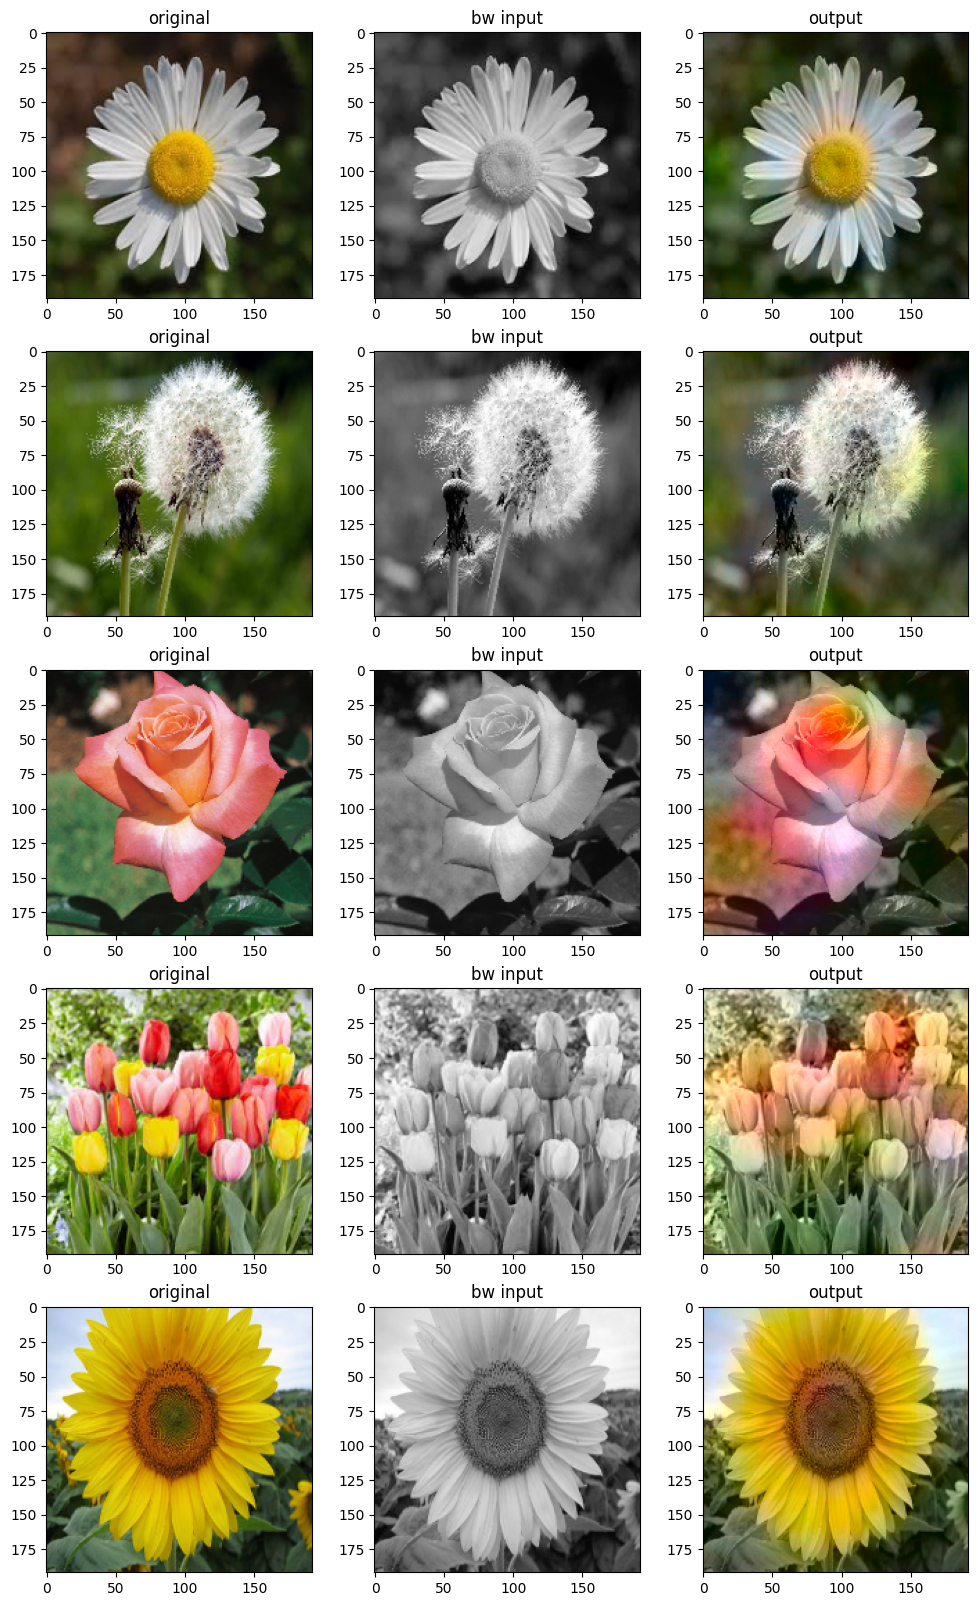

<Figure size 640x480 with 0 Axes>

In [21]:
eval_images([f'{data_test}daisy/images.jpg', 
            f'{data_test}dandelion/dandelion-seed-head.jpg',
            f'{data_test}roses/23521.jpg',
            f'{data_test}tulips/download1.jpg',
            f'{data}sunflowers/40410814_fba3837226_n.jpg'])    